# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import warnings
from collections import namedtuple
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import OneHotEncoder

# Load data

In [2]:
data = pd.read_csv('./data/Adult/train_Adult_cleaned.csv')
labels = pd.read_csv('./data/Adult/train_Adult_labels.csv')

In [3]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,6,77516,1,13,3,9,4,1,2,2174,0,40,1
1,50,2,83311,1,13,1,5,3,1,2,0,0,13,1
2,38,1,215646,4,9,2,7,4,1,2,0,0,40,1
3,53,1,234721,3,7,1,7,3,5,2,0,0,40,1
4,28,1,338409,1,13,1,6,1,5,1,0,0,40,13


# Save discrete columns and continuous columns separately

In [4]:
discrete_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
continuous_columns = [col for col in list(data.columns) if col not in discrete_columns]

# Some parameters

In [5]:
max_clusters = min(len(data), 10)  # maximum number of clusters to consider when using Bayesian Gaussian Mixture
weight_threshold = 0.005  # values under this threshold is considered useless in the Bayesian Gaussian Mixture
random_state = 42

SpanInfo = namedtuple('SpanInfo', ['dim', 'activation_fn'])  # make it simple

# Fit and transform continuous and discrete values separately

# Continuous
- For each continuous column $C_i$ use `sklearn.mixture.BayesianGaussianMixture` to find the number of valid components. Results that are smaller than `weight_threshold` are considered useless. Determine `n_components`
- For every value $c_{i, j}$ in the continuous column $C_i$, compute the probability of $c_{i, j}$ coming from each component. For instance, if there are 3 valid components found after BGM, compute 3 probabilities $\rho_1, \rho_2, \rho_3$
- Using the calculated probabilities, we randomly choose one component according to the probability of each component. Represent the chosen component as one-hot vector and normalize the value $c_{i, j}$ using the mean and std of that component
- Let the normalized value be $\alpha_{i, j}$ and the one-hot vector be $\beta_{i, j}$. The transformed value is $\alpha_{i, j} \oplus \beta_{i, j}$ ($\oplus$ means concatenated) The shape of the result is `[1 + number of components]`

# Discrete
- Create a one hot encoding of each value
- Shape of the result is `[number of categories]`


The final row should look something like this:

$$r_j = \alpha_{1, j} \oplus \beta_{1, j} ... \oplus \alpha_{N_c, j} \oplus \beta_{N_c, 1} \oplus d_{1, j} \oplus ... \oplus d_{N_d, j}$$

where:
- $N_c$ : number of continuous columns
- $N_d$ : number of discrete columns

In [6]:
def fit_and_transform_continuous(column_name:str, data:pd.Series, weight_threshold=0.005):
    bgm = BayesianGaussianMixture(
        n_components=max_clusters,
        weight_concentration_prior_type='dirichlet_process',
        weight_concentration_prior=0.001,
        random_state=random_state
    )
    
    data = data.to_numpy()
    data = data.reshape(-1, 1)
    # fit Bayesian Gaussian Mixture
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        bgm.fit(data)
    valid_component_indicator = bgm.weights_ > weight_threshold  # weights close to 0 are not effective components
    num_components = sum(valid_component_indicator)  # number of effective components (modes)

    # Save the transformation information for future reference
    transform_info = {
        'column_name': column_name,
        'column_type': 'continuous',
        'transform': bgm,
        'valid_component_indicator': valid_component_indicator,
        'output_info': [SpanInfo(1, 'tanh'), SpanInfo(num_components, 'softmax')],
        'output_dimensions': 1 + num_components  # 1 normalized value + number of effective gaussian mixtures
    }

    # transform
    means = bgm.means_.reshape((1, max_clusters))  # means for each gaussian mixture
    means = means[:, valid_component_indicator]  # only the effective ones
    stds = np.sqrt(bgm.covariances_).reshape((1, max_clusters))  # stds for each gaussian mixture
    stds = stds[:, valid_component_indicator]  # only the effective ones
    
    normalized_values = (data - means) / (4 * stds)  # normaluze the values using the components
    component_probs = bgm.predict_proba(data)  # probability that each data belongs to a certain Gaussian Mixture
    component_probs = component_probs[:, valid_component_indicator]  # only the effective ones
    
    selected_component = np.zeros(len(data), dtype=int)
    for i in range(len(data)):
        component_prob_t = component_probs[i] + 1e-6
        component_prob_t /= component_prob_t.sum()  # probability of each Gaussian Mixture of ith data
        # randomly choose one component based on the calculated probabilities
        selected_component[i] = np.random.choice(np.arange(valid_component_indicator.sum()), p=component_prob_t)
    
    aranged = np.arange(len(data))
    normalized = normalized_values[aranged, selected_component].reshape([-1, 1])  # select the normalized value of the randomly chosen mixture
    normalized = np.clip(normalized, -0.99, 0.99)  # make normalize value fall into tanh range
    normalized = normalized[:, 0]  # final normalized value alpha_{i, j}
    
    # one hot vector transform selected component according to the paper
    ohe = OneHotEncoder()
    ohe.fit(selected_component.reshape(-1, 1))
    selected_component = ohe.transform(selected_component.reshape(-1, 1)).toarray()
    
    row = [normalized.reshape(-1, 1), selected_component]
    transformed = np.concatenate(row, axis=1)  # alpha_{i, j} \oplus beta_{i, j}
    print(f"{column_name} shape = {transformed.shape}, num_components = {num_components}")
    return transformed, transform_info  # concatenation of normalized value and the selected component

# one hot encode
def fit_and_transform_discrete(column_name:str, data:pd.Series):
    ohe = OneHotEncoder()
    
    data = data.to_numpy()
    data = data.reshape(-1, 1)
    ohe.fit(data)
    num_categories = len(ohe.categories_[0])  # for some reason the values are wrapped in a list
    transform_info = {
        'column_name': column_name,
        'column_type': 'discrete',
        'transform': ohe,
        'output_info': [SpanInfo(num_categories, 'softmax')],
        'output_dimensions': num_categories  # one hot encoded
    }

    transformed = ohe.transform(data).toarray()
    print(f"{column_name} shape = {transformed.shape}, num_categories = {num_categories}")

    return transformed, transform_info

In [7]:
train_data = []
output_info_list = []
for col in list(data.columns):
    if col in continuous_columns:
        continuous_data = data[col]
        transformed, transform_info = fit_and_transform_continuous(col, continuous_data)
        train_data.append(transformed)
        output_info_list.append(transform_info)
    elif col in discrete_columns:
        discrete_data = data[col]
        transformed, transform_info = fit_and_transform_discrete(col, discrete_data)
        train_data.append(transformed)
        output_info_list.append(transform_info)

train_data = np.concatenate(train_data, axis=1)

age shape = (2000, 10), num_components = 9
workclass shape = (2000, 8), num_categories = 8
fnlwgt shape = (2000, 10), num_components = 9
education shape = (2000, 16), num_categories = 16
education-num shape = (2000, 8), num_components = 7
marital-status shape = (2000, 6), num_categories = 6
occupation shape = (2000, 15), num_categories = 15
relationship shape = (2000, 6), num_categories = 6
race shape = (2000, 5), num_categories = 5
sex shape = (2000, 2), num_categories = 2
capital-gain shape = (2000, 5), num_components = 4
capital-loss shape = (2000, 3), num_components = 2
hours-per-week shape = (2000, 10), num_components = 9
native-country shape = (2000, 36), num_categories = 36


In [8]:
log_frequency = True

In [9]:
data_length = len(train_data)

In [10]:
n_discrete_columns = len(discrete_columns)  # number of discrete columns

In [11]:
discrete_column_matrix_st = np.zeros(n_discrete_columns, dtype='int32')
rid_by_cat_cols = []  # rid_by_cat_cols[a][b] => list of all rows with the a-th discrete column equal to b

In [12]:
st = 0
for column_info in output_info_list:
    if column_info['column_name'] in discrete_columns:
        span_info = column_info['output_info'][0]
        ed = st + span_info.dim  # st + number of categories

        rid_by_cat = []
        for j in range(span_info.dim):
            rid_by_cat.append(np.nonzero(train_data[:, st + j])[0])
        rid_by_cat_cols.append(rid_by_cat)
        st = ed
    else:
        st += sum([span_info.dim for span_info in column_info['output_info']])
assert st == train_data.shape[1]

In [13]:
max_category = max(
    [column_info['output_info'][0].dim for column_info in output_info_list if column_info['column_type'] == 'discrete']
)

- `discrete_column_category_prob`: PMF for all discrete columns. Each row contains PMF for each categories in that column. Probabiliy mass of each value is the logarithm of its frequency in that column.
- `discrete_column_n_category`: number of categories of each discrete column
- `n_categories`: total number of categories across **all** discrete columns

In [14]:
discrete_column_cond_st = np.zeros(n_discrete_columns, dtype='int32')
discrete_column_n_category = np.zeros(n_discrete_columns, dtype='int32')  # number of categories of each discrete column
discrete_column_category_prob = np.zeros((n_discrete_columns, max_category))  # probs of each category of each discrete column (PMF of each column)
n_categories = sum([  # total number of categories across all discrete columns
    column_info['output_info'][0].dim for column_info in output_info_list if column_info['column_type'] == 'discrete'
])

In [15]:
st = 0
current_id = 0
current_cond_st = 0
for column_info in output_info_list:
    if column_info['column_type'] == 'discrete':  # all one hot encoded
        span_info = column_info['output_info'][0]
        ed = st + span_info.dim
        category_freq = np.sum(train_data[:, st:ed], axis=0)  # frequency of each category
        if log_frequency:
            category_freq = np.log(category_freq + 1)  # convert to log frequency
        category_prob = category_freq / np.sum(category_freq)  # calculate probability mass of each function
        discrete_column_category_prob[current_id, :span_info.dim] = category_prob
        discrete_column_cond_st[current_id] = current_cond_st
        discrete_column_n_category[current_id] = span_info.dim  # save number of categories of each discrete column
        current_cond_st += span_info.dim
        current_id += 1
        st = ed
    else:  # continuous column
        st += sum([span_info.dim for span_info in column_info['output_info']])

In [16]:
data_dim = train_data.shape[1]
data_dim

140

# Models

In [17]:
class Residual(nn.Module):
    def __init__(self, i, o):
        super(Residual, self).__init__()
        self.fc = nn.Linear(i, o)
        self.bn = nn.BatchNorm1d(o)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc(x)
        out = self.bn(out)
        out = self.relu(out)
        return torch.cat([out, x], dim=1)

In [18]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, discriminator_dim, pac=10):
        super(Discriminator, self).__init__()
        dim = input_dim * pac
        self.pac = pac
        self.pacdim = dim
        seq = []
        for item in list(discriminator_dim):
            seq += [nn.Linear(dim, item), nn.LeakyReLU(0.2), nn.Dropout(0.5)]
            dim = item
        seq += [nn.Linear(dim, 1)]
        self.seq = nn.Sequential(*seq)

    def forward(self, x):
        assert x.size()[0] % self.pac == 0
        return self.seq(x.view(-1, self.pacdim))

    def calc_gradient_penalty(self, real_data, fake_data, device='cpu', pac=10, lambda_=10):
        alpha = torch.rand(real_data.size(0) // pac, 1, 1, device=device)
        alpha = alpha.repeat(1, pac, real_data.size(1))
        alpha = alpha.view(-1, real_data.size(1))

        interpolates = alpha * real_data + ((1 - alpha) * fake_data)

        disc_interpolates = self(interpolates)

        gradients = torch.autograd.grad(
            outputs=disc_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones(disc_interpolates.size(), device=device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]

        gradients_view = gradients.view(-1, pac * real_data.size(1)).norm(2, dim=1) - 1
        gradient_penalty = ((gradients_view) ** 2).mean() * lambda_

        return gradient_penalty

In [19]:
class Generator(nn.Module):
    def __init__(self, embedding_dim, generator_dim, data_dim):
        super(Generator, self).__init__()
        dim = embedding_dim
        seq = []
        for item in list(generator_dim):
            seq += [Residual(dim, item)]
            dim += item
        seq.append(nn.Linear(dim, data_dim))
        self.seq = nn.Sequential(*seq)

    def forward(self, x):
        data = self.seq(x)
        return data

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
embedding_dim = 128
generator_dim = (256, 256)
discriminator_dim = (256, 256)
generator_lr = 2e-4
generator_decay = 1e-6
discriminator_lr = 2e-4
discriminator_decay = 1e-6
batch_size=500
discriminator_step = 1
epochs = 300
pac = 10
cuda = True
verbose = True

In [22]:
generator = Generator(
    embedding_dim=embedding_dim+n_categories,
    generator_dim=generator_dim,
    data_dim=data_dim
).to(device)

discriminator = Discriminator(
    input_dim=data_dim+n_categories,
    discriminator_dim=discriminator_dim,
    pac=pac
).to(device)

In [23]:
optimizerG = optim.Adam(
    generator.parameters(),
    lr=generator_lr,
    betas=(0.5, 0.9),
    weight_decay=generator_decay
)

optimizerD = optim.Adam(
    discriminator.parameters(),
    lr=discriminator_lr,
    betas=(0.5, 0.9),
    weight_decay=discriminator_decay
)

In [24]:
# Normal Distribution
mean = torch.zeros(batch_size, embedding_dim, device=device)
std = mean + 1

In [25]:
loss_values = pd.DataFrame(columns=['epoch', 'Generator Loss', 'Discriminator Loss'])

In [26]:
epoch_iterator = tqdm(range(epochs), disable=(not verbose))
if verbose:
    description = 'Generator ({gen:.2f}) | Discriminator ({dis:.2f})'
    epoch_iterator.set_description(description.format(gen=0, dis=0))

Generator (0.00) | Discriminator (0.00):   0%|                                                 | 0/300 [00:00<?, ?it/s]

In [27]:
steps_per_epoch = max(len(train_data) // batch_size, 1)

In [28]:
def random_choice_prob_index(discrete_column_id):
    probs = discrete_column_category_prob[discrete_column_id]  # probability of each categories in the selected discrete_column
    r = np.expand_dims(np.random.rand(probs.shape[0]), axis=1)  # randomly select one category based on the PMF of the selected column
    return (probs.cumsum(axis=1) > r).argmax(axis=1)

def sample_condvec(batch):
    if n_discrete_columns == 0:
        return None
    discrete_column_id = np.random.choice(np.arange(n_discrete_columns), batch)  # randomly select one discrete column

    cond = np.zeros((batch, n_categories), dtype='float32')  # concatenation of mask vectors
    mask = np.zeros((batch, n_discrete_columns), dtype='float32')
    mask[np.arange(batch), discrete_column_id] = 1
    category_id_in_col = random_choice_prob_index(discrete_column_id)  # the category chosen within the selected discrete column
    category_id = discrete_column_cond_st[discrete_column_id] + category_id_in_col
    cond[np.arange(batch), category_id] = 1  # set that value to one

    return cond, mask, discrete_column_id, category_id_in_col

In [29]:
def sample_data(data, n, col, opt):
    if col is None:
        idx = np.random.randint(len(data), size=n)
        return data[idx]
        
    idx = []
    for c, o in zip(col, opt):
        idx.append(np.random.choice(rid_by_cat_cols[c][o]))  # sample one data with the corresponding condition uniformly

    return data[idx]

In [30]:
def gumbel_softmax(logits, tau=1, hard=False, eps=1e-10, dim=-1):
    for _ in range(10):
        transformed = F.gumbel_softmax(logits, tau=tau, hard=hard, eps=eps, dim=dim)
        if not torch.isnan(transformed).any():
            return transformed

    raise ValueError('gumbel_softmax returning NaN.')

def apply_activate(data):
    data_t = []
    st = 0
    for column_info in output_info_list:
        for span_info in column_info['output_info']:
            if span_info.activation_fn == 'tanh':
                ed = st + span_info.dim
                data_t.append(torch.tanh(data[:, st:ed]))
                st = ed
            elif span_info.activation_fn == 'softmax':
                ed = st + span_info.dim
                transformed = gumbel_softmax(data[:, st:ed], tau=0.2)
                data_t.append(transformed)
                st = ed
            else:
                raise ValueError(f'Unexpected activation function {span_info.activation_fn}')

    return torch.cat(data_t, dim=1)

In [31]:
def cond_loss(data, c, m):
    loss = []
    st = 0
    st_c = 0
    for column_info in output_info_list:
        for span_info in column_info['output_info']:
            if column_info['column_type'] != 'discrete':
                # not discrete column
                st += span_info.dim
            else:
                ed = st + span_info.dim
                ed_c = st_c + span_info.dim
                tmp = F.cross_entropy(
                    data[:, st:ed], torch.argmax(c[:, st_c:ed_c], dim=1), reduction='none'
                )
                loss.append(tmp)
                st = ed
                st_c = ed_c

    loss = torch.stack(loss, dim=1)

    return (loss * m).sum() / data.size()[0]

# Train

In [32]:
for i in epoch_iterator:
    for id_ in range(steps_per_epoch):
        # discriminator
        for n in range(discriminator_step):
            fakez = torch.normal(mean=mean, std=std)  # from standard deviation

            condvec = sample_condvec(batch_size)
            if condvec is None:
                c1, m1, col, opt = None, None, None, None
                real = sample_data(train_data, batch_size, col, opt)

            else:
                c1, m1, col, opt = condvec
                # c1: cond vector
                # m1: mask
                # col: randomly chosen discrete column id
                # opt: randomly chosen category of the corresponding column_id
                c1 = torch.from_numpy(c1).to(device)
                m1 = torch.from_numpy(m1).to(device)
                fakez = torch.cat([fakez, c1], dim=1)  # input z \oplus cond

                perm = np.arange(batch_size)  # permutation for shuffling
                np.random.shuffle(perm)
                real = sample_data(train_data, batch_size, col[perm], opt[perm])  # sampled data based on the given condition
                c2 = c1[perm]

            fake = generator(fakez)
            fakeact = apply_activate(fake)

            real = torch.from_numpy(real.astype('float32')).to(device)

            # real and fake data pacs
            if c1 is not None:
                fake_cat = torch.cat([fakeact, c1], dim=1)
                real_cat = torch.cat([real, c2], dim=1)
            else:
                real_cat = real
                fake_cat = fakeact

            y_fake = discriminator(fake_cat)
            y_real = discriminator(real_cat)

            pen = discriminator.calc_gradient_penalty(
                real_cat, fake_cat, device, pac
            )
            loss_d = -(torch.mean(y_real) - torch.mean(y_fake))

            optimizerD.zero_grad(set_to_none=False)
            pen.backward(retain_graph=True)
            loss_d.backward()
            optimizerD.step()

        # generator
        fakez = torch.normal(mean=mean, std=std)
        condvec = sample_condvec(batch_size)

        if condvec is None:
            c1, m1, col, opt = None, None, None, None
        else:
            c1, m1, col, opt = condvec
            c1 = torch.from_numpy(c1).to(device)
            m1 = torch.from_numpy(m1).to(device)
            fakez = torch.cat([fakez, c1], dim=1)

        fake = generator(fakez)
        fakeact = apply_activate(fake)

        if c1 is not None:
            y_fake = discriminator(torch.cat([fakeact, c1], dim=1))
        else:
            y_fake = discriminator(fakeact)

        if condvec is None:
            cross_entropy = 0
        else:
            cross_entropy = cond_loss(fake, c1, m1)

        loss_g = -torch.mean(y_fake) + cross_entropy

        optimizerG.zero_grad(set_to_none=False)
        loss_g.backward()
        optimizerG.step()

    generator_loss = loss_g.detach().cpu().item()
    discriminator_loss = loss_d.detach().cpu().item()

    epoch_loss_df = pd.DataFrame({
        'Epoch': [i],
        'Generator Loss': [generator_loss],
        'Discriminator Loss': [discriminator_loss]
    })
    if not loss_values.empty:
        loss_values = pd.concat([loss_values, epoch_loss_df]).reset_index(drop=True)
    else:
        loss_values = epoch_loss_df

    if verbose:
        epoch_iterator.set_description(
            description.format(gen=generator_loss, dis=discriminator_loss)
        )

Generator (-0.48) | Discriminator (-0.18): 100%|█████████████████████████████████████| 300/300 [01:01<00:00,  4.92it/s]


# Plot Loss

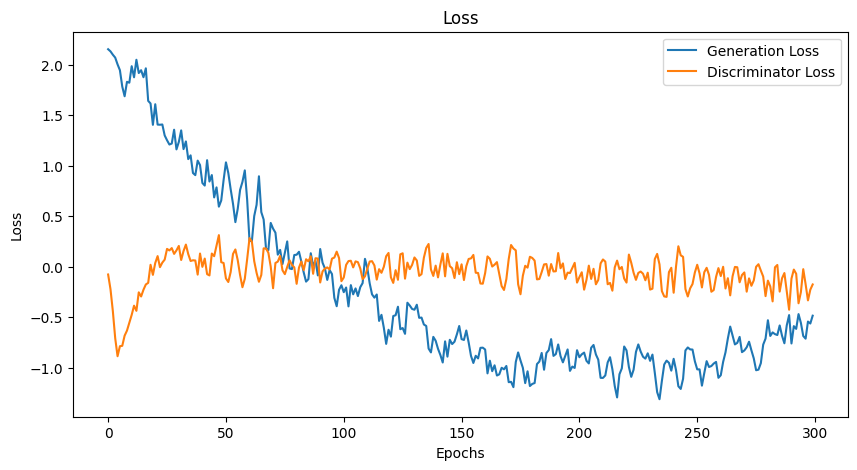

In [35]:
plt.figure(figsize=(10, 5))

plt.plot(loss_values['Epoch'], loss_values['Generator Loss'], label='Generation Loss')
plt.plot(loss_values['Epoch'], loss_values['Discriminator Loss'], label='Discriminator Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Sample

In [36]:
num_samples = len(train_data)
sample_condition_column = None
sample_condition_value = None
dataframe = True

In [37]:
def convert_column_name_value_to_id(column_name, value):
    discrete_counter = 0
    column_id = 0
    for column_transform_info in output_info_list:
        if column_transform_info['column_name'] == column_name:
            break
        if column_transform_info['column_type'] == 'discrete':
            discrete_counter += 1

        column_id += 1
    else:
        raise ValueError(f"{column_name} doesn't exist in the data")

    ohe = column_transform_info['transform']
    data = pd.DataFrame([value], columns=[column_transform_info['column_name']])
    one_hot = ohe.transform(data).to_numpy()
    if sum(one_hot) == 0:
        raise ValueError(f"The value `{value}` doesn't exist in the column `{column_name}`")
    return {
        'discrete_column_id': discrete_counter,
        'column_id': column_id,
        'value_id': np.argmax(one_hot)
    }

def inverse_transform_continuous(column_transform_info, column_data, sigmas, st):
    gm = column_transform_info['transform']
    # data contains [normalized data, selected component index]
    data = pd.DataFrame(column_data[:, :2]).astype(float)
    data[data.columns[1]] = np.argmax(column_data[:, 1:], axis=1)
    if sigmas is not None:
        selected_normalized_value = np.random.normal(data.iloc[:, 0], sigmas[st])
        data.iloc[:, 0] = selected_normalized_value

    if not isinstance(data, np.ndarray):
        data = data.to_numpy()

    normalized = np.clip(data[:, 0], -1, 1)  # normalized values
    means = gm.means_.reshape([-1])
    stds = np.sqrt(gm.covariances_).reshape([-1])
    selected_component = data[:, 1].round().astype(int)
    selected_component = selected_component.clip(0, column_transform_info['valid_component_indicator'].sum() - 1)
    std_t = stds[column_transform_info['valid_component_indicator']][selected_component]
    mean_t = means[column_transform_info['valid_component_indicator']][selected_component]
    recovered_data = normalized * 0.4 * std_t + mean_t

    return recovered_data

def inverse_transform_discrete(column_transform_info, column_data):
    ohe = column_transform_info['transform']
    data = pd.DataFrame(column_data)

    if not isinstance(data, np.ndarray):
        data = data.to_numpy()

    if data.ndim == 1:
        data = data.reshape(-1, 1)

    indices = np.argmax(data, axis=1)
    result = pd.Series(indices).astype(int)

    return result

def inverse_transform(data, sigmas=None):
    st = 0
    recovered_column_data_list = []
    column_names = []
    for column_transform_info in output_info_list:
        dim = column_transform_info['output_dimensions']
        column_data = data[:, st:st+dim]
        if column_transform_info['column_type'] == 'continuous':
            recovered_column_data = inverse_transform_continuous(column_transform_info, column_data, sigmas, st)
        else:
            recovered_column_data = inverse_transform_discrete(column_transform_info, column_data)
            
        recovered_column_data_list.append(recovered_column_data)
        column_names.append(column_transform_info['column_name'])
        st += dim

    recovered_data = np.column_stack(recovered_column_data_list)
    recovered_data = pd.DataFrame(recovered_data, columns=column_names)
    if not dataframe:
        recovered_data = recovered_data.to_numpy()

    return recovered_data

def generate_cond_from_condition_column_info(condition_info, batch):
    vec = np.zeros((batch, n_categories), dtype='float32')
    id_ = discrete_column_matrix_st[condition_info['discrete_column_id']]
    id_ += condition_info['value_id']
    vec[:, id_] = 1
    return vec

def sample_original_condvec(batch):
    if n_discrete_columns == 0:
        return None

    category_freq = discrete_column_category_prob.flatten()
    category_freq = category_freq[category_freq != 0]
    category_freq = category_freq / np.sum(category_freq)
    col_idxs = np.random.choice(np.arange(len(category_freq)), batch, p=category_freq)
    cond = np.zeros((batch, n_categories), dtype='float32')
    cond[np.arange(batch), col_idxs] = 1

    return cond

In [38]:
def sample(n, condition_column=None, condition_value=None):
    if condition_column is not None and condition_value is not None:
        condition_info = convert_column_name_value_to_id(condition_column, condition_value)
        global_condition_vec = generate_cond_from_condition_column_info(condition_info, batch_size)
    else:
        global_condition_vec = None

    steps = n // batch_size + 1
    data = []
    for i in range(steps):
        mean = torch.zeros(batch_size, embedding_dim)
        std = mean + 1
        fakez = torch.normal(mean=mean, std=std).to(device)

        if global_condition_vec is not None:
            condvec = global_condition_vec.copy()
        else:
            condvec = sample_original_condvec(batch_size)

        if condvec is None:
            pass
        else:
            c1 = condvec
            c1 = torch.from_numpy(c1).to(device)
            fakez = torch.cat([fakez, c1], dim=1)

        fake = generator(fakez)
        fakeact = apply_activate(fake)
        data.append(fakeact.detach().cpu().numpy())

    data = np.concatenate(data, axis=0)
    data = data[:n]

    return inverse_transform(data)

In [39]:
sampled = sample(num_samples, sample_condition_column, sample_condition_value)

In [43]:
for col in list(sampled.columns):
    sampled[col] = sampled[col].astype(int)

In [46]:
sampled

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,57,1,300591,5,9,0,9,2,0,0,3,1,35,1
1,56,2,337829,3,9,2,8,0,0,1,21,0,35,8
2,49,1,114462,3,4,0,8,2,0,1,4,1827,50,1
3,48,1,51762,5,14,1,5,3,0,0,27,-2,49,1
4,22,1,52776,1,9,2,0,3,0,1,-2,-1,49,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,38,0,186657,3,4,2,9,2,0,1,14,0,39,28
1996,55,1,56595,3,14,1,4,3,0,0,-5,0,35,1
1997,57,1,248664,0,4,0,7,2,0,1,4313,0,39,1
1998,23,5,52576,1,9,3,8,3,0,0,46,0,39,1
